In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from matplotlib import pyplot as plt

In [2]:
# Load CIFAR10 dataset
(training_set, validation_set), dataset_info = tfds.load(
    'cifar10',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# Look at the shape of our dataset
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 10
Total Number of Training Images: 35000
Total Number of Validation Images: 15000 



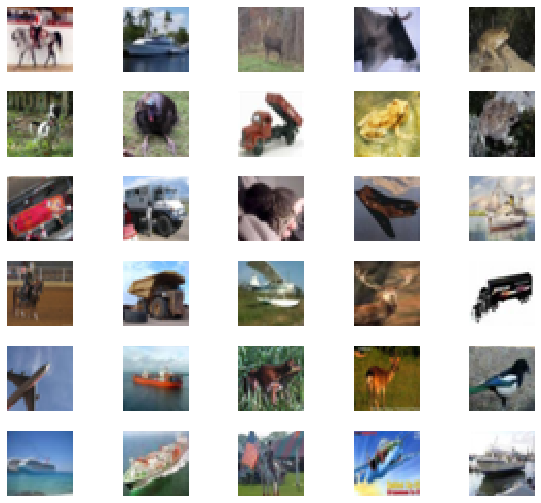

In [4]:
# Check out a few specific samples
image_batch = []
for i, example in enumerate(training_set.take(30)):
    image_batch.append(example[0])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.axis('off')

In [5]:
# Reformat to fit MobileNet V2 and split into batches
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 64

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [6]:
# Setup MobileNet V2 feature extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [7]:
# Freeze layers of pretrained model
feature_extractor.trainable = False

In [8]:
# Attach classification head
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
# Train our classification head to take input from our feature extractor
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
547/547 [==============================] - 1102s 2s/step - loss: 0.6506 - accuracy: 0.7774 - val_loss: 0.4842 - val_accuracy: 0.8329
Epoch 2/3
547/547 [==============================] - 1003s 2s/step - loss: 0.4432 - accuracy: 0.8457 - val_loss: 0.4602 - val_accuracy: 0.8395
Epoch 3/3
547/547 [==============================] - 994s 2s/step - loss: 0.4045 - accuracy: 0.8584 - val_loss: 0.4350 - val_accuracy: 0.8509


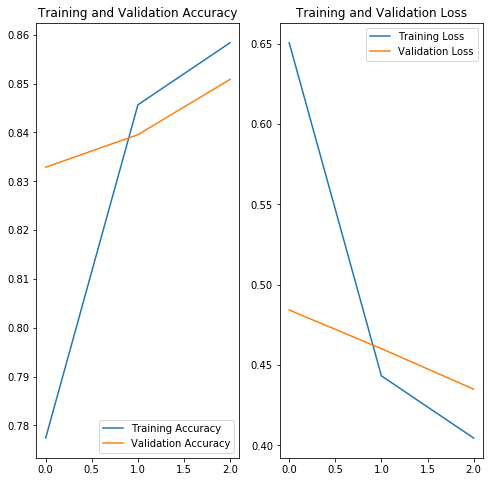

In [10]:
# Plot valid accuracy / loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [12]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['airplane' 'cat' 'cat' 'frog' 'cat' 'frog' 'frog' 'dog' 'truck' 'bird'
 'cat' 'horse' 'ship' 'frog' 'airplane' 'bird' 'horse' 'horse' 'frog'
 'airplane' 'ship' 'automobile' 'automobile' 'dog' 'horse' 'airplane'
 'bird' 'ship' 'airplane' 'airplane' 'truck' 'deer' 'deer' 'frog' 'truck'
 'cat' 'ship' 'dog' 'dog' 'automobile' 'dog' 'ship' 'horse' 'frog'
 'airplane' 'bird' 'airplane' 'deer' 'bird' 'horse' 'automobile' 'frog'
 'horse' 'ship' 'airplane' 'airplane' 'airplane' 'ship' 'frog' 'ship'
 'bird' 'ship' 'truck' 'horse']


In [13]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 4 3 6 3 6 6 5 9 2 3 7 8 6 0 2 4 3 2 0 8 1 1 5 7 0 2 8 4 0 9 4 4 6 9 3 8
 5 4 1 5 8 7 6 0 2 0 2 2 7 1 6 7 8 0 0 0 8 6 8 2 8 9 7]
Predicted labels:  [0 3 3 6 3 6 6 5 9 2 3 7 8 6 0 2 7 7 6 0 8 1 1 5 7 0 2 8 0 0 9 4 4 6 9 3 8
 5 5 1 5 8 7 6 0 2 0 4 2 7 1 6 7 8 0 0 0 8 6 8 2 8 9 7]


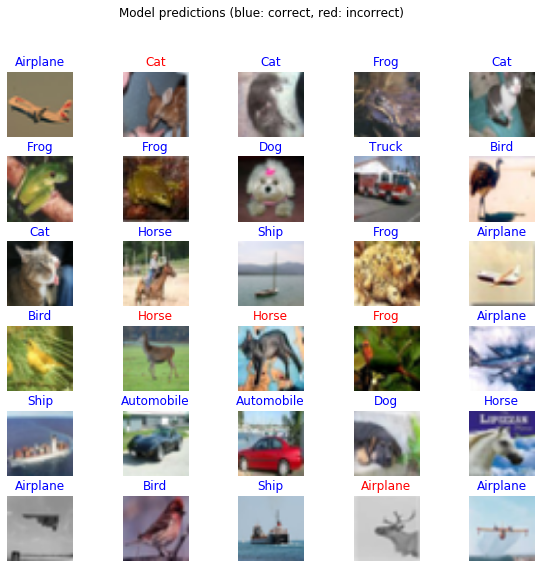

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [15]:
# setup model with Inception V3 pretrained model as feature extractor
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'cifar10', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
# Plot valid accuracy / loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# setup model with Bit pretrained model as feature extractor
IMAGE_RES = 224

(training_set, validation_set), dataset_info = tfds.load(
    'cifar10', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/bit/s-r152x4/1"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_Bit = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_Bit.summary()

In [ ]:
model_Bit.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3

history = model_Bit.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
# Plot valid accuracy / loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()